In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys


import functions.parse_data as parse
import functions.handy_functions as hf
import torch.nn as nn
import torch

from multivariate_quantile_regression.network_model import QuantileNetwork

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import os

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

/tmp/ipykernel_234478/2115483293.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-03-22 12:34:14.135554: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-22 12:34:14.170574: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-22 12:3

In [2]:
# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    # CUDA is available, so let's set default device to GPU
    torch.set_default_device(0)
    print("CUDA is available. Using GPU.")
else:
    # CUDA is not available, so let's use the CPU
    print("CUDA is not available. Using CPU.")

# Example usage:
tensor = torch.randn(3, 3)  # Create a tensor on the selected device
print("Tensor is on device:", tensor.device)

CUDA is available. Using GPU.
Tensor is on device: cuda:0


## Example Pinball loss / Quantile loss

In [3]:
tau=0.1
y_hat=3
y=np.linspace(y_hat-10,y_hat+10,100)

# Calculate loss
loss=(1-tau)*(np.abs(y-y_hat))
y_larger=y>y_hat
loss[y_larger]=tau*(np.abs(y[y_larger]-y_hat))

In [4]:
loss=(1-tau)*(np.abs(y-y_hat))
y_larger=y>y_hat

loss[y_larger]=tau*(np.abs(y[y_larger]-y_hat))

In [5]:
tau=0.1
y_hat=3
u=np.linspace(-100,100,1000)
u_ints=np.unique(np.ceil(u))
u_ticks=u_ints[np.nonzero((u_ints%2)==0)]

def plot_function(tau):
    
    loss=(1-tau)*(np.abs(u))
    y_larger=u<0
    loss[y_larger]=tau*(np.abs(u[y_larger]))

    plt.plot(u,loss)
    plt.rcParams["figure.figsize"] = [10, 5]
    plt.grid()
    plt.xticks(u_ticks)
    plt.xlim([-10,10])
    plt.ylim([-1,8])
    plt.legend([r'$\mathcal{L}(y_{\tau},y)$',r'$y_{\tau}$'])
    plt.xlabel(r"$u=y_{\tau}-y$")
    plt.ylabel(r'$\mathcal{L}$')
    plt.title(r'Example of the Quantile loss / Pinball loss function')
    plt.show()
    
interact(plot_function, tau = widgets.FloatSlider(value=0.1,
                                               min=0.0,
                                               max=1.0,
                                               step=0.01))

interactive(children=(FloatSlider(value=0.1, description='tau', max=1.0, step=0.01), Output()), _dom_classes=(…

<function __main__.plot_function(tau)>

## Plot for report

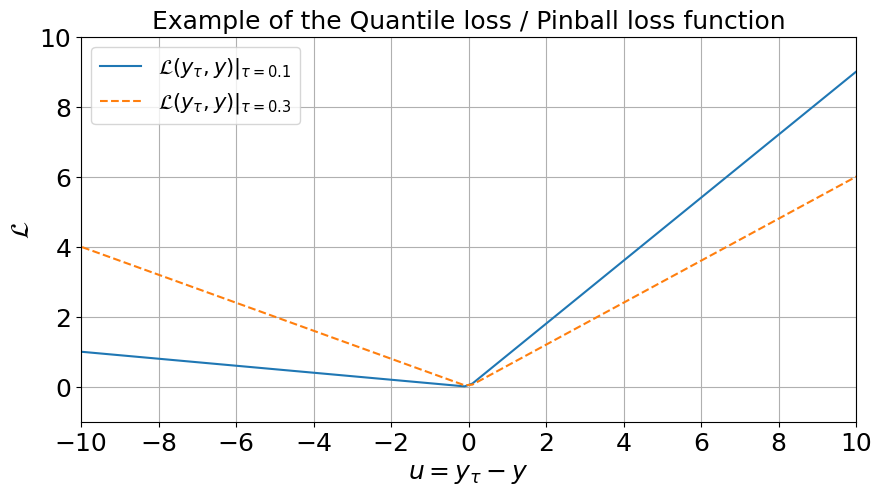

In [6]:
tau=0.1
u=np.linspace(-100,100,1000)
u_ints=np.unique(np.ceil(u))
u_ticks=u_ints[np.nonzero((u_ints%2)==0)]    

loss=(1-tau)*(np.abs(u))
y_larger=u<0
loss[y_larger]=tau*(np.abs(u[y_larger]))

tau_2=0.4
loss_2=(1-tau_2)*(np.abs(u))
loss_2[y_larger]=tau_2*(np.abs(u[y_larger]))

fontsize=18

plt.plot(u,loss)
plt.plot(u,loss_2,'--')
plt.rcParams["figure.figsize"] = [10, 5]
plt.grid()
plt.xticks(u_ticks,fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlim([-10,10])
plt.ylim([-1,10])
plt.legend([r'$\mathcal{L}(y_{\tau},y)|_{\tau =0.1}$',r'$\mathcal{L}(y_{\tau},y)|_{\tau =0.3}$'],fontsize=fontsize-3)
plt.xlabel(r"$u=y_{\tau}-y$",fontsize=fontsize)
plt.ylabel(r'$\mathcal{L}$',fontsize=fontsize)
plt.title(r'Example of the Quantile loss / Pinball loss function',fontsize=fontsize)
plt.show()

## Example Quantile Regression Neural Networks (QRNN)

In [7]:
def draw_sample_sin(n_samps, sigma):
    x=np.random.uniform(low=0,high=2*np.pi,size=n_samps)
    noise=np.random.normal(loc=0,scale=sigma,size=n_samps)
    y=np.sin(x)+noise
    return x,y

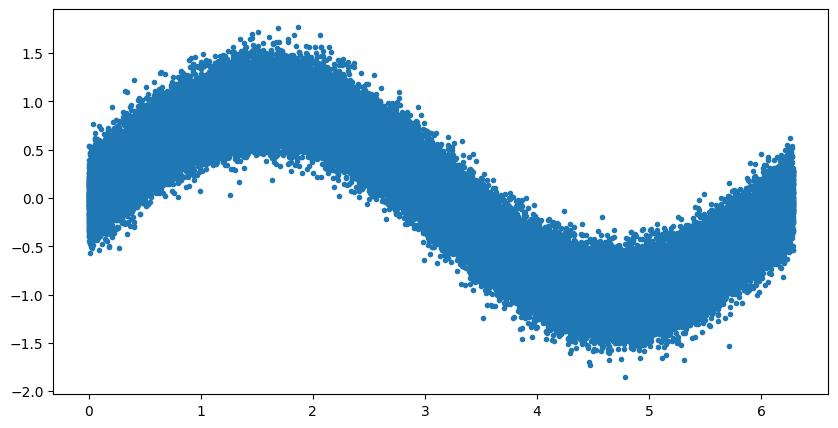

In [18]:
x,y = draw_sample_sin(100000,0.2)
plt.plot(x,y,'.')

In [19]:
x=np.array([x]).T
X_train, X_test, y_train, y_test=train_test_split(x,y,test_size=0.05)


import random

val_size=0.05
validation_indices=np.array(random.sample(range(len(X_train)), int(len(X_train)*val_size)))
train_indices=[i for i in range(len(X_train)) if np.any(validation_indices==i)==False]

quantiles=np.array([0.1,0.5,0.9])
batch_size=500


In [20]:
nepochs=200
quantiles=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
model=QuantileNetwork(quantiles=quantiles)

# Add everything but the output layer
sequence=nn.Sequential(
    nn.Linear(1,64),
    nn.ReLU(),
    nn.Linear(64, len(quantiles)*1) #Output dimesion is number of quantiles times number of target variables
)
model.fit(X_train,y_train, 
          train_indices, 
          validation_indices, 
          batch_size=batch_size,
          nepochs=nepochs,
          sequence=sequence)

Epoch 1


/home/edgelab/.local/lib/python3.10/site-packages/torch/utils/_device.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
Batch number:   0%|          | 0/181 [00:00<?, ?it/s]

Batch number: 100%|██████████| 181/181 [00:00<00:00, 494.82it/s]

Training loss [2.755302] Validation loss [1.2043867]
----New best validation loss---- [1.2043867]
Epoch 2



Batch number: 100%|██████████| 181/181 [00:00<00:00, 626.93it/s]

Training loss [1.1451901] Validation loss [1.067978]
----New best validation loss---- [1.067978]
Epoch 3



Batch number: 100%|██████████| 181/181 [00:00<00:00, 577.14it/s]

Training loss [1.0391319] Validation loss [0.98493624]
----New best validation loss---- [0.98493624]
Epoch 4



Batch number: 100%|██████████| 181/181 [00:00<00:00, 478.20it/s]

Training loss [0.96186215] Validation loss [0.9081569]
----New best validation loss---- [0.9081569]
Epoch 5



Batch number: 100%|██████████| 181/181 [00:00<00:00, 550.52it/s]

Training loss [0.87596065] Validation loss [0.83004296]
----New best validation loss---- [0.83004296]
Epoch 6



Batch number: 100%|██████████| 181/181 [00:00<00:00, 412.12it/s]

Training loss [0.81393236] Validation loss [0.77698904]
----New best validation loss---- [0.77698904]
Epoch 7



Batch number: 100%|██████████| 181/181 [00:00<00:00, 426.62it/s]

Training loss [0.7656457] Validation loss [0.7337431]
----New best validation loss---- [0.7337431]
Epoch 8



Batch number: 100%|██████████| 181/181 [00:00<00:00, 440.20it/s]

Training loss [0.72081] Validation loss [0.69904304]
----New best validation loss---- [0.69904304]
Epoch 9



Batch number: 100%|██████████| 181/181 [00:00<00:00, 531.59it/s]

Training loss [0.6857811] Validation loss [0.67085767]
----New best validation loss---- [0.67085767]
Epoch 10



Batch number: 100%|██████████| 181/181 [00:00<00:00, 439.83it/s]


Training loss [0.659572] Validation loss [0.6435538]
----New best validation loss---- [0.6435538]
Epoch 11


Batch number: 100%|██████████| 181/181 [00:00<00:00, 427.25it/s]

Training loss [0.64003754] Validation loss [0.630662]
----New best validation loss---- [0.630662]
Epoch 12



Batch number: 100%|██████████| 181/181 [00:00<00:00, 612.04it/s]


Training loss [0.6274392] Validation loss [0.6226144]
----New best validation loss---- [0.6226144]
Epoch 13


Batch number: 100%|██████████| 181/181 [00:00<00:00, 554.71it/s]

Training loss [0.617411] Validation loss [0.61396885]
----New best validation loss---- [0.61396885]
Epoch 14



Batch number: 100%|██████████| 181/181 [00:00<00:00, 449.16it/s]


Training loss [0.6103627] Validation loss [0.60877156]
----New best validation loss---- [0.60877156]
Epoch 15


Batch number: 100%|██████████| 181/181 [00:00<00:00, 552.03it/s]

Training loss [0.60461223] Validation loss [0.6013777]
----New best validation loss---- [0.6013777]
Epoch 16



Batch number: 100%|██████████| 181/181 [00:00<00:00, 558.66it/s]

Training loss [0.601101] Validation loss [0.59840846]
----New best validation loss---- [0.59840846]
Epoch 17



Batch number: 100%|██████████| 181/181 [00:00<00:00, 554.24it/s]

Training loss [0.5978162] Validation loss [0.59465194]
----New best validation loss---- [0.59465194]
Epoch 18



Batch number: 100%|██████████| 181/181 [00:00<00:00, 547.76it/s]

Training loss [0.5960014] Validation loss [0.5996389]
Epoch 19



Batch number: 100%|██████████| 181/181 [00:00<00:00, 413.58it/s]

Training loss [0.594149] Validation loss [0.5927308]
----New best validation loss---- [0.5927308]
Epoch 20



Batch number: 100%|██████████| 181/181 [00:00<00:00, 525.17it/s]

Training loss [0.59319544] Validation loss [0.59727776]
Epoch 21



Batch number: 100%|██████████| 181/181 [00:00<00:00, 431.36it/s]

Training loss [0.5920814] Validation loss [0.59045124]
----New best validation loss---- [0.59045124]
Epoch 22



Batch number: 100%|██████████| 181/181 [00:00<00:00, 553.39it/s]

Training loss [0.59123945] Validation loss [0.5866424]
----New best validation loss---- [0.5866424]
Epoch 23



Batch number: 100%|██████████| 181/181 [00:00<00:00, 455.24it/s]

Training loss [0.58965063] Validation loss [0.5950735]
Epoch 24



Batch number: 100%|██████████| 181/181 [00:00<00:00, 422.60it/s]

Training loss [0.589223] Validation loss [0.59201187]
Epoch 25



Batch number: 100%|██████████| 181/181 [00:00<00:00, 451.93it/s]


Training loss [0.5898885] Validation loss [0.5952235]
Epoch 26


Batch number: 100%|██████████| 181/181 [00:00<00:00, 548.46it/s]

Training loss [0.589142] Validation loss [0.5915926]
Epoch 27



Batch number: 100%|██████████| 181/181 [00:00<00:00, 431.72it/s]

Training loss [0.589776] Validation loss [0.5849228]
----New best validation loss---- [0.5849228]
Epoch 28



Batch number: 100%|██████████| 181/181 [00:00<00:00, 466.52it/s]

Training loss [0.58898264] Validation loss [0.58844745]
Epoch 29



Batch number: 100%|██████████| 181/181 [00:00<00:00, 552.42it/s]

Training loss [0.58846635] Validation loss [0.5846526]
----New best validation loss---- [0.5846526]
Epoch 30



Batch number: 100%|██████████| 181/181 [00:00<00:00, 459.71it/s]

Training loss [0.58906615] Validation loss [0.5905676]
Epoch 31



Batch number: 100%|██████████| 181/181 [00:00<00:00, 596.51it/s]

Training loss [0.58856094] Validation loss [0.5951305]
Epoch 32



Batch number: 100%|██████████| 181/181 [00:00<00:00, 628.85it/s]

Training loss [0.5880982] Validation loss [0.5849253]
Epoch 33



Batch number: 100%|██████████| 181/181 [00:00<00:00, 626.75it/s]

Training loss [0.5871264] Validation loss [0.5899035]
Epoch 34



Batch number: 100%|██████████| 181/181 [00:00<00:00, 626.21it/s]

Training loss [0.5883468] Validation loss [0.588986]
Epoch 35



Batch number: 100%|██████████| 181/181 [00:00<00:00, 627.95it/s]

Training loss [0.587956] Validation loss [0.58479357]
Epoch 36



Batch number: 100%|██████████| 181/181 [00:00<00:00, 633.64it/s]

Training loss [0.58723766] Validation loss [0.58867973]
Epoch 37



Batch number: 100%|██████████| 181/181 [00:00<00:00, 632.28it/s]

Training loss [0.5881538] Validation loss [0.58901924]
Epoch 38



Batch number: 100%|██████████| 181/181 [00:00<00:00, 624.55it/s]

Training loss [0.58892846] Validation loss [0.5866419]
Epoch 39



Batch number: 100%|██████████| 181/181 [00:00<00:00, 548.25it/s]

Training loss [0.5862322] Validation loss [0.5848638]
Epoch 40



Batch number: 100%|██████████| 181/181 [00:00<00:00, 566.00it/s]

Training loss [0.5864193] Validation loss [0.5908505]
Epoch 41



Batch number: 100%|██████████| 181/181 [00:00<00:00, 502.87it/s]

Training loss [0.5879972] Validation loss [0.58449185]
----New best validation loss---- [0.58449185]
Epoch 42



Batch number: 100%|██████████| 181/181 [00:00<00:00, 427.47it/s]

Training loss [0.58796024] Validation loss [0.58834887]
Epoch 43



Batch number: 100%|██████████| 181/181 [00:00<00:00, 541.88it/s]

Training loss [0.58722615] Validation loss [0.59126186]
Epoch 44



Batch number: 100%|██████████| 181/181 [00:00<00:00, 542.03it/s]

Training loss [0.5866803] Validation loss [0.588737]
Epoch 45



Batch number: 100%|██████████| 181/181 [00:00<00:00, 556.48it/s]

Training loss [0.58726984] Validation loss [0.59536237]
Epoch 46



Batch number: 100%|██████████| 181/181 [00:00<00:00, 550.47it/s]

Training loss [0.58647066] Validation loss [0.5928298]
Epoch 47



Batch number: 100%|██████████| 181/181 [00:00<00:00, 529.26it/s]

Training loss [0.58738226] Validation loss [0.5861291]
Epoch 48



Batch number: 100%|██████████| 181/181 [00:00<00:00, 543.93it/s]

Training loss [0.58724636] Validation loss [0.5886706]
Epoch 49



Batch number: 100%|██████████| 181/181 [00:00<00:00, 532.38it/s]

Training loss [0.5868323] Validation loss [0.5892995]
Epoch 50



Batch number: 100%|██████████| 181/181 [00:00<00:00, 432.17it/s]

Training loss [0.58647543] Validation loss [0.5871179]
Epoch 51



Batch number: 100%|██████████| 181/181 [00:00<00:00, 565.72it/s]

Training loss [0.5869811] Validation loss [0.58920014]
Epoch 52



Batch number: 100%|██████████| 181/181 [00:00<00:00, 437.55it/s]

Training loss [0.5865304] Validation loss [0.5877504]
Epoch 53



Batch number: 100%|██████████| 181/181 [00:00<00:00, 540.27it/s]

Training loss [0.5870009] Validation loss [0.5886083]
Epoch 54



Batch number: 100%|██████████| 181/181 [00:00<00:00, 454.66it/s]


Training loss [0.58746374] Validation loss [0.59084505]
Epoch 55


Batch number: 100%|██████████| 181/181 [00:00<00:00, 511.88it/s]

Training loss [0.5866868] Validation loss [0.5878646]
Epoch 56



Batch number: 100%|██████████| 181/181 [00:00<00:00, 529.91it/s]

Training loss [0.587595] Validation loss [0.5870794]
Epoch 57



Batch number: 100%|██████████| 181/181 [00:00<00:00, 483.26it/s]

Training loss [0.58652383] Validation loss [0.58743584]
Epoch 58



Batch number: 100%|██████████| 181/181 [00:00<00:00, 548.19it/s]

Training loss [0.5864626] Validation loss [0.5847179]
Epoch 59



Batch number: 100%|██████████| 181/181 [00:00<00:00, 422.58it/s]

Training loss [0.586934] Validation loss [0.5835549]
----New best validation loss---- [0.5835549]
Epoch 60



Batch number: 100%|██████████| 181/181 [00:00<00:00, 431.12it/s]

Training loss [0.5871805] Validation loss [0.59048307]
Epoch 61



Batch number: 100%|██████████| 181/181 [00:00<00:00, 457.11it/s]

Training loss [0.5854997] Validation loss [0.58805615]
Epoch 62



Batch number: 100%|██████████| 181/181 [00:00<00:00, 550.91it/s]

Training loss [0.58547586] Validation loss [0.5870529]
Epoch 63



Batch number: 100%|██████████| 181/181 [00:00<00:00, 425.89it/s]

Training loss [0.58810246] Validation loss [0.5852193]
Epoch 64



Batch number: 100%|██████████| 181/181 [00:00<00:00, 575.62it/s]

Training loss [0.5878639] Validation loss [0.58439]
Epoch 65



Batch number: 100%|██████████| 181/181 [00:00<00:00, 550.21it/s]

Training loss [0.5856183] Validation loss [0.5878044]
Epoch 66



Batch number: 100%|██████████| 181/181 [00:00<00:00, 527.15it/s]

Training loss [0.5854854] Validation loss [0.5853506]
Epoch 67



Batch number: 100%|██████████| 181/181 [00:00<00:00, 539.13it/s]

Training loss [0.5862622] Validation loss [0.58553785]
Epoch 68



Batch number: 100%|██████████| 181/181 [00:00<00:00, 538.60it/s]

Training loss [0.5864533] Validation loss [0.58695185]
Epoch 69



Batch number: 100%|██████████| 181/181 [00:00<00:00, 563.72it/s]

Training loss [0.5855864] Validation loss [0.58367]
Epoch 70



Batch number: 100%|██████████| 181/181 [00:00<00:00, 453.33it/s]


Training loss [0.5862084] Validation loss [0.58455205]
Epoch 71


Batch number: 100%|██████████| 181/181 [00:00<00:00, 535.36it/s]

Training loss [0.58537173] Validation loss [0.5889222]
Epoch 72



Batch number: 100%|██████████| 181/181 [00:00<00:00, 465.46it/s]

Training loss [0.586799] Validation loss [0.58617026]
Epoch 73



Batch number: 100%|██████████| 181/181 [00:00<00:00, 539.68it/s]

Training loss [0.5866584] Validation loss [0.5958154]
Epoch 74



Batch number: 100%|██████████| 181/181 [00:00<00:00, 572.35it/s]

Training loss [0.58655155] Validation loss [0.5855649]
Epoch 75



Batch number: 100%|██████████| 181/181 [00:00<00:00, 527.13it/s]

Training loss [0.58639354] Validation loss [0.58527845]
Epoch 76



Batch number: 100%|██████████| 181/181 [00:00<00:00, 547.70it/s]

Training loss [0.5845918] Validation loss [0.58562833]
Epoch 77



Batch number: 100%|██████████| 181/181 [00:00<00:00, 447.09it/s]

Training loss [0.58572197] Validation loss [0.58585465]
Epoch 78



Batch number: 100%|██████████| 181/181 [00:00<00:00, 450.38it/s]


Training loss [0.5861824] Validation loss [0.5861986]
Epoch 79


Batch number: 100%|██████████| 181/181 [00:00<00:00, 535.19it/s]

Training loss [0.58606476] Validation loss [0.5874926]
Epoch 80



Batch number: 100%|██████████| 181/181 [00:00<00:00, 468.14it/s]

Training loss [0.586745] Validation loss [0.5840453]
Epoch 81



Batch number: 100%|██████████| 181/181 [00:00<00:00, 551.79it/s]

Training loss [0.5871193] Validation loss [0.5897921]
Epoch 82



Batch number: 100%|██████████| 181/181 [00:00<00:00, 549.03it/s]

Training loss [0.5864772] Validation loss [0.582007]
----New best validation loss---- [0.582007]
Epoch 83



Batch number: 100%|██████████| 181/181 [00:00<00:00, 541.22it/s]

Training loss [0.58619815] Validation loss [0.5821635]
Epoch 84



Batch number: 100%|██████████| 181/181 [00:00<00:00, 540.21it/s]

Training loss [0.5864439] Validation loss [0.58881277]
Epoch 85



Batch number: 100%|██████████| 181/181 [00:00<00:00, 532.60it/s]

Training loss [0.58617634] Validation loss [0.58609056]
Epoch 86



Batch number: 100%|██████████| 181/181 [00:00<00:00, 544.93it/s]

Training loss [0.58568335] Validation loss [0.5843427]
Epoch 87



Batch number: 100%|██████████| 181/181 [00:00<00:00, 512.42it/s]

Training loss [0.5858659] Validation loss [0.58899814]
Epoch 88



Batch number: 100%|██████████| 181/181 [00:00<00:00, 551.41it/s]

Training loss [0.5855641] Validation loss [0.5822933]
Epoch 89



Batch number: 100%|██████████| 181/181 [00:00<00:00, 550.16it/s]

Training loss [0.5857528] Validation loss [0.5875772]
Epoch 90



Batch number: 100%|██████████| 181/181 [00:00<00:00, 564.70it/s]

Training loss [0.5859199] Validation loss [0.59311104]
Epoch 91



Batch number: 100%|██████████| 181/181 [00:00<00:00, 578.09it/s]

Training loss [0.58600974] Validation loss [0.5860818]
Epoch 92



Batch number: 100%|██████████| 181/181 [00:00<00:00, 421.86it/s]

Training loss [0.58544266] Validation loss [0.5893739]
Epoch 93



Batch number: 100%|██████████| 181/181 [00:00<00:00, 537.01it/s]

Training loss [0.58633995] Validation loss [0.59065914]
Epoch 94



Batch number: 100%|██████████| 181/181 [00:00<00:00, 392.66it/s]

Training loss [0.58474374] Validation loss [0.59009254]
Epoch 95



Batch number: 100%|██████████| 181/181 [00:00<00:00, 426.08it/s]

Training loss [0.5865276] Validation loss [0.5879407]
Epoch 96



Batch number: 100%|██████████| 181/181 [00:00<00:00, 475.57it/s]

Training loss [0.5856127] Validation loss [0.59028417]
Epoch 97



Batch number: 100%|██████████| 181/181 [00:00<00:00, 434.01it/s]

Training loss [0.58671534] Validation loss [0.5891346]
Epoch 98



Batch number: 100%|██████████| 181/181 [00:00<00:00, 518.82it/s]

Training loss [0.58565086] Validation loss [0.58567005]
Epoch 99



Batch number: 100%|██████████| 181/181 [00:00<00:00, 429.60it/s]

Training loss [0.585988] Validation loss [0.58616185]
Epoch 100



Batch number: 100%|██████████| 181/181 [00:00<00:00, 470.14it/s]

Training loss [0.58624417] Validation loss [0.58578354]
Epoch 101



Batch number: 100%|██████████| 181/181 [00:00<00:00, 423.24it/s]

Training loss [0.58638495] Validation loss [0.5839497]
Epoch 102



Batch number: 100%|██████████| 181/181 [00:00<00:00, 559.39it/s]

Training loss [0.5859442] Validation loss [0.58644706]
Epoch 103



Batch number: 100%|██████████| 181/181 [00:00<00:00, 547.43it/s]

Training loss [0.5860211] Validation loss [0.5883575]
Epoch 104



Batch number: 100%|██████████| 181/181 [00:00<00:00, 560.83it/s]

Training loss [0.5854269] Validation loss [0.5906191]
Epoch 105



Batch number: 100%|██████████| 181/181 [00:00<00:00, 546.51it/s]

Training loss [0.5862737] Validation loss [0.59159315]
Epoch 106



Batch number: 100%|██████████| 181/181 [00:00<00:00, 517.81it/s]

Training loss [0.58676195] Validation loss [0.585561]
Epoch 107



Batch number: 100%|██████████| 181/181 [00:00<00:00, 431.48it/s]

Training loss [0.58639574] Validation loss [0.5899606]
Epoch 108



Batch number: 100%|██████████| 181/181 [00:00<00:00, 471.32it/s]

Training loss [0.5857033] Validation loss [0.5804712]
----New best validation loss---- [0.5804712]
Epoch 109



Batch number: 100%|██████████| 181/181 [00:00<00:00, 551.09it/s]

Training loss [0.5843634] Validation loss [0.58585024]
Epoch 110



Batch number: 100%|██████████| 181/181 [00:00<00:00, 414.05it/s]

Training loss [0.5855142] Validation loss [0.58229274]
Epoch 111



Batch number: 100%|██████████| 181/181 [00:00<00:00, 539.75it/s]

Training loss [0.5867759] Validation loss [0.58864605]
Epoch 112



Batch number: 100%|██████████| 181/181 [00:00<00:00, 425.89it/s]

Training loss [0.58738625] Validation loss [0.5891191]
Epoch 113



Batch number: 100%|██████████| 181/181 [00:00<00:00, 467.88it/s]

Training loss [0.58550674] Validation loss [0.5890394]
Epoch 114



Batch number: 100%|██████████| 181/181 [00:00<00:00, 478.20it/s]

Training loss [0.5861321] Validation loss [0.58791983]
Epoch 115



Batch number: 100%|██████████| 181/181 [00:00<00:00, 439.79it/s]

Training loss [0.5864919] Validation loss [0.5845035]
Epoch 116



Batch number: 100%|██████████| 181/181 [00:00<00:00, 548.11it/s]

Training loss [0.5857817] Validation loss [0.5834837]
Epoch 117



Batch number: 100%|██████████| 181/181 [00:00<00:00, 550.89it/s]

Training loss [0.58657885] Validation loss [0.59090316]
Epoch 118



Batch number: 100%|██████████| 181/181 [00:00<00:00, 422.76it/s]

Training loss [0.58459085] Validation loss [0.59033525]
Epoch 119



Batch number: 100%|██████████| 181/181 [00:00<00:00, 529.62it/s]

Training loss [0.58559185] Validation loss [0.58184093]
Epoch 120



Batch number: 100%|██████████| 181/181 [00:00<00:00, 531.96it/s]

Training loss [0.58710617] Validation loss [0.5869243]
Epoch 121



Batch number: 100%|██████████| 181/181 [00:00<00:00, 537.58it/s]

Training loss [0.58673626] Validation loss [0.58443695]
Epoch 122



Batch number: 100%|██████████| 181/181 [00:00<00:00, 544.44it/s]

Training loss [0.5846429] Validation loss [0.5874723]
Epoch 123



Batch number: 100%|██████████| 181/181 [00:00<00:00, 516.42it/s]

Training loss [0.58651847] Validation loss [0.588198]
Epoch 124



Batch number: 100%|██████████| 181/181 [00:00<00:00, 539.73it/s]

Training loss [0.5860891] Validation loss [0.58276176]
Epoch 125



Batch number: 100%|██████████| 181/181 [00:00<00:00, 540.91it/s]

Training loss [0.58543843] Validation loss [0.5872213]
Epoch 126



Batch number: 100%|██████████| 181/181 [00:00<00:00, 535.18it/s]

Training loss [0.58618975] Validation loss [0.58362585]
Epoch 127



Batch number: 100%|██████████| 181/181 [00:00<00:00, 541.25it/s]

Training loss [0.58583856] Validation loss [0.5906144]
Epoch 128



Batch number: 100%|██████████| 181/181 [00:00<00:00, 552.31it/s]

Training loss [0.5850566] Validation loss [0.58556545]
Epoch 129



Batch number: 100%|██████████| 181/181 [00:00<00:00, 547.85it/s]

Training loss [0.5865462] Validation loss [0.5807036]
Epoch 130



Batch number: 100%|██████████| 181/181 [00:00<00:00, 548.96it/s]

Training loss [0.58692616] Validation loss [0.589725]
Epoch 131



Batch number: 100%|██████████| 181/181 [00:00<00:00, 542.90it/s]

Training loss [0.5842509] Validation loss [0.5846591]
Epoch 132



Batch number: 100%|██████████| 181/181 [00:00<00:00, 573.97it/s]

Training loss [0.58602184] Validation loss [0.58553934]
Epoch 133



Batch number: 100%|██████████| 181/181 [00:00<00:00, 519.49it/s]

Training loss [0.58541024] Validation loss [0.5854418]
Epoch 134



Batch number: 100%|██████████| 181/181 [00:00<00:00, 550.86it/s]

Training loss [0.58472425] Validation loss [0.5858554]
Epoch 135



Batch number: 100%|██████████| 181/181 [00:00<00:00, 533.32it/s]

Training loss [0.5868495] Validation loss [0.58851343]
Epoch 136



Batch number: 100%|██████████| 181/181 [00:00<00:00, 567.47it/s]

Training loss [0.5863287] Validation loss [0.5862192]
Epoch 137



Batch number: 100%|██████████| 181/181 [00:00<00:00, 566.44it/s]

Training loss [0.58547103] Validation loss [0.5829321]
Epoch 138



Batch number: 100%|██████████| 181/181 [00:00<00:00, 540.96it/s]

Training loss [0.5844756] Validation loss [0.58890665]
Epoch 139



Batch number: 100%|██████████| 181/181 [00:00<00:00, 531.68it/s]

Training loss [0.5867063] Validation loss [0.586787]
Epoch 140



Batch number: 100%|██████████| 181/181 [00:00<00:00, 581.31it/s]

Training loss [0.58706874] Validation loss [0.5895079]
Epoch 141



Batch number: 100%|██████████| 181/181 [00:00<00:00, 532.67it/s]

Training loss [0.58597016] Validation loss [0.5894606]
Epoch 142



Batch number: 100%|██████████| 181/181 [00:00<00:00, 528.06it/s]

Training loss [0.5850297] Validation loss [0.5878757]
Epoch 143



Batch number: 100%|██████████| 181/181 [00:00<00:00, 491.94it/s]

Training loss [0.58533764] Validation loss [0.5810946]
Epoch 144



Batch number: 100%|██████████| 181/181 [00:00<00:00, 554.16it/s]

Training loss [0.5853338] Validation loss [0.5894717]
Epoch 145



Batch number: 100%|██████████| 181/181 [00:00<00:00, 550.49it/s]

Training loss [0.58654135] Validation loss [0.5874784]
Epoch 146



Batch number: 100%|██████████| 181/181 [00:00<00:00, 554.22it/s]

Training loss [0.5856734] Validation loss [0.5848782]
Epoch 147



Batch number: 100%|██████████| 181/181 [00:00<00:00, 563.11it/s]

Training loss [0.5856394] Validation loss [0.5865425]
Epoch 148



Batch number: 100%|██████████| 181/181 [00:00<00:00, 551.63it/s]

Training loss [0.5849429] Validation loss [0.58274287]
Epoch 149



Batch number: 100%|██████████| 181/181 [00:00<00:00, 549.07it/s]

Training loss [0.58517] Validation loss [0.5939232]
Epoch 150



Batch number: 100%|██████████| 181/181 [00:00<00:00, 553.58it/s]

Training loss [0.58785814] Validation loss [0.58582133]
Epoch 151



Batch number: 100%|██████████| 181/181 [00:00<00:00, 551.41it/s]

Training loss [0.5858721] Validation loss [0.5856285]
Epoch 152



Batch number: 100%|██████████| 181/181 [00:00<00:00, 553.86it/s]

Training loss [0.5870585] Validation loss [0.5825547]
Epoch 153



Batch number: 100%|██████████| 181/181 [00:00<00:00, 556.07it/s]

Training loss [0.58435106] Validation loss [0.5864547]
Epoch 154



Batch number: 100%|██████████| 181/181 [00:00<00:00, 441.05it/s]

Training loss [0.5843674] Validation loss [0.5828294]
Epoch 155



Batch number: 100%|██████████| 181/181 [00:00<00:00, 438.52it/s]

Training loss [0.5853989] Validation loss [0.5868787]
Epoch 156



Batch number: 100%|██████████| 181/181 [00:00<00:00, 508.75it/s]

Training loss [0.5865596] Validation loss [0.5980975]
Epoch 157



Batch number: 100%|██████████| 181/181 [00:00<00:00, 602.13it/s]


Training loss [0.58647823] Validation loss [0.58574533]
Epoch 158


Batch number: 100%|██████████| 181/181 [00:00<00:00, 566.30it/s]

Training loss [0.5856409] Validation loss [0.5853369]
Epoch 159



Batch number: 100%|██████████| 181/181 [00:00<00:00, 639.92it/s]

Training loss [0.5865631] Validation loss [0.5792708]
----New best validation loss---- [0.5792708]
Epoch 160



Batch number: 100%|██████████| 181/181 [00:00<00:00, 572.68it/s]

Training loss [0.586434] Validation loss [0.58532596]
Epoch 161



Batch number: 100%|██████████| 181/181 [00:00<00:00, 595.42it/s]

Training loss [0.5865765] Validation loss [0.5901867]
Epoch 162



Batch number: 100%|██████████| 181/181 [00:00<00:00, 434.93it/s]

Training loss [0.5859001] Validation loss [0.5853814]
Epoch 163



Batch number: 100%|██████████| 181/181 [00:00<00:00, 456.72it/s]

Training loss [0.5860962] Validation loss [0.5868785]


Epoch 164


Batch number: 100%|██████████| 181/181 [00:00<00:00, 572.08it/s]

Training loss [0.5868771] Validation loss [0.58513373]
Epoch 165



Batch number: 100%|██████████| 181/181 [00:00<00:00, 479.01it/s]

Training loss [0.5851262] Validation loss [0.58650005]
Epoch 166



Batch number: 100%|██████████| 181/181 [00:00<00:00, 564.48it/s]

Training loss [0.5863276] Validation loss [0.5913456]
Epoch 167



Batch number: 100%|██████████| 181/181 [00:00<00:00, 575.94it/s]

Training loss [0.5853786] Validation loss [0.58732206]
Epoch 168



Batch number: 100%|██████████| 181/181 [00:00<00:00, 435.47it/s]

Training loss [0.58548254] Validation loss [0.58962756]
Epoch 169



Batch number: 100%|██████████| 181/181 [00:00<00:00, 556.09it/s]

Training loss [0.5872842] Validation loss [0.5919213]
Epoch 170



Batch number: 100%|██████████| 181/181 [00:00<00:00, 555.79it/s]

Training loss [0.58537024] Validation loss [0.5884257]
Epoch 171



Batch number: 100%|██████████| 181/181 [00:00<00:00, 616.06it/s]

Training loss [0.5856328] Validation loss [0.5834193]


Epoch 172


Batch number: 100%|██████████| 181/181 [00:00<00:00, 416.92it/s]

Training loss [0.58588076] Validation loss [0.5836179]
Epoch 173



Batch number: 100%|██████████| 181/181 [00:00<00:00, 435.28it/s]

Training loss [0.5855607] Validation loss [0.5881854]
Epoch 174



Batch number: 100%|██████████| 181/181 [00:00<00:00, 536.72it/s]

Training loss [0.5846933] Validation loss [0.5893078]
Epoch 175



Batch number: 100%|██████████| 181/181 [00:00<00:00, 574.92it/s]

Training loss [0.58584416] Validation loss [0.5876235]
Epoch 176



Batch number: 100%|██████████| 181/181 [00:00<00:00, 517.72it/s]

Training loss [0.5854466] Validation loss [0.58894086]
Epoch 177



Batch number: 100%|██████████| 181/181 [00:00<00:00, 548.81it/s]

Training loss [0.5855918] Validation loss [0.5793081]
Epoch 178



Batch number: 100%|██████████| 181/181 [00:00<00:00, 557.63it/s]

Training loss [0.58547586] Validation loss [0.58633685]
Epoch 179



Batch number: 100%|██████████| 181/181 [00:00<00:00, 433.77it/s]

Training loss [0.5851338] Validation loss [0.5877365]
Epoch 180



Batch number: 100%|██████████| 181/181 [00:00<00:00, 376.93it/s]

Training loss [0.5850644] Validation loss [0.5808835]
Epoch 181



Batch number: 100%|██████████| 181/181 [00:00<00:00, 516.38it/s]

Training loss [0.5861474] Validation loss [0.583774]
Epoch 182



Batch number: 100%|██████████| 181/181 [00:00<00:00, 532.19it/s]

Training loss [0.58407336] Validation loss [0.5885371]
Epoch 183



Batch number: 100%|██████████| 181/181 [00:00<00:00, 507.09it/s]

Training loss [0.58603257] Validation loss [0.58564407]
Epoch 184



Batch number: 100%|██████████| 181/181 [00:00<00:00, 437.16it/s]

Training loss [0.5854006] Validation loss [0.583804]
Epoch 185



Batch number: 100%|██████████| 181/181 [00:00<00:00, 486.29it/s]

Training loss [0.5874963] Validation loss [0.58753216]
Epoch 186



Batch number: 100%|██████████| 181/181 [00:00<00:00, 474.34it/s]

Training loss [0.5860401] Validation loss [0.58762884]
Epoch 187



Batch number: 100%|██████████| 181/181 [00:00<00:00, 450.26it/s]


Training loss [0.58402383] Validation loss [0.58848226]
Epoch 188


Batch number: 100%|██████████| 181/181 [00:00<00:00, 512.51it/s]

Training loss [0.58537054] Validation loss [0.5797736]
Epoch 189



Batch number: 100%|██████████| 181/181 [00:00<00:00, 504.13it/s]

Training loss [0.58583426] Validation loss [0.58374083]
Epoch 190



Batch number: 100%|██████████| 181/181 [00:00<00:00, 469.06it/s]

Training loss [0.5858473] Validation loss [0.58890575]
Epoch 191



Batch number: 100%|██████████| 181/181 [00:00<00:00, 454.10it/s]


Training loss [0.58616906] Validation loss [0.5891936]
Epoch 192


Batch number: 100%|██████████| 181/181 [00:00<00:00, 472.72it/s]

Training loss [0.58657086] Validation loss [0.58674365]
Epoch 193



Batch number: 100%|██████████| 181/181 [00:00<00:00, 493.34it/s]

Training loss [0.5855884] Validation loss [0.5880224]
Epoch 194



Batch number: 100%|██████████| 181/181 [00:00<00:00, 609.59it/s]


Training loss [0.58582944] Validation loss [0.58847076]
Epoch 195


Batch number: 100%|██████████| 181/181 [00:00<00:00, 610.40it/s]


Training loss [0.5858204] Validation loss [0.58416986]
Epoch 196


Batch number: 100%|██████████| 181/181 [00:00<00:00, 451.45it/s]


Training loss [0.5851308] Validation loss [0.58568436]
Epoch 197


Batch number: 100%|██████████| 181/181 [00:00<00:00, 542.35it/s]

Training loss [0.58620816] Validation loss [0.5832406]
Epoch 198



Batch number: 100%|██████████| 181/181 [00:00<00:00, 422.31it/s]


Training loss [0.58550286] Validation loss [0.5802477]
Epoch 199


Batch number: 100%|██████████| 181/181 [00:00<00:00, 476.23it/s]

Training loss [0.5861735] Validation loss [0.5906007]
Epoch 200



Batch number: 100%|██████████| 181/181 [00:00<00:00, 493.88it/s]

Training loss [0.58561164] Validation loss [0.5828658]
Best model out of total max epochs found at epoch 159


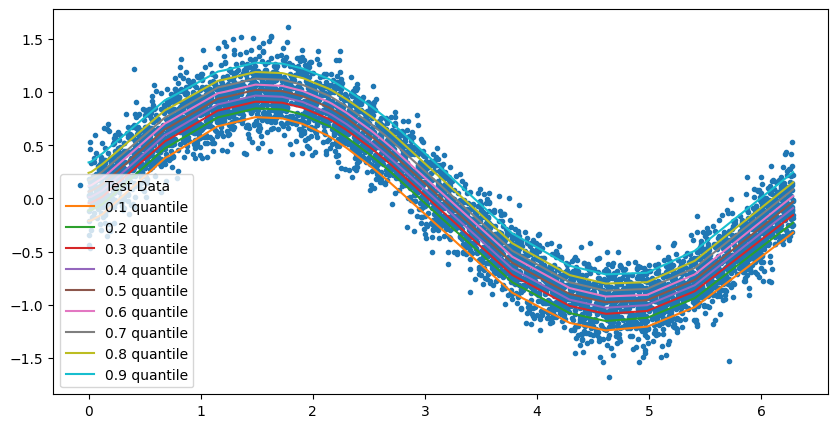

In [25]:
sort_indices=np.argsort(X_test[:,0])
X_test_sort=X_test[sort_indices]
y_test_sort=y_test[sort_indices]
preds = model.predict(X_test_sort)

plt.plot(X_test_sort,y_test_sort,'.')
plt.plot(X_test_sort,preds)

legend=["Test Data"]
quantiles_str=[str(quant)+" quantile" for quant in quantiles]
legend.extend(quantiles_str)
plt.legend(legend)
plt.show()

In [26]:
QuantileNetwork.quant_rate(y_test_sort,preds)

array([0.0994, 0.2016, 0.3018, 0.4176, 0.5328, 0.6366, 0.7428, 0.8362,
       0.9258])

In [27]:
def cdf(pred, x, quantiles):
    r"""
    Approximate the posterior CDF for given inputs x.

    Propagates the inputs in x forward through the network and
    approximates the posterior CDF by a piecewise linear function.

    The piecewise linear function is given by its values at approximate
    quantiles :math:`x_\tau`` for :math:`\tau = \{0.0, \tau_1, \ldots,
    \tau_k, 1.0\}` where :math:`\tau_k` are the quantiles to be estimated
    by the network. The values for :math:`x_{0.0}` and :math:`x_{1.0}` are
    computed using

    .. math::

        x_{0.0} = 2.0 x_{\tau_1} - x_{\tau_2}

        x_{1.0} = 2.0 x_{\tau_k} - x_{\tau_{k-1}}

    Arguments:

        x(np.array): Array of shape (n, m) containing n inputs for which
                        to predict the conditional quantiles.

    Returns:

        Tuple (xs, fs) containing the :math:`x`-values in xs and corresponding
        values of the posterior CDF :math:`F(x)` in fs.

    """
    if len(x.shape) > 1:
        s = x.shape[:-1] + (len(quantiles) + 2,)
    else:
        s = (1, len(quantiles) + 2)

    y_pred = np.zeros(s)
    y_pred[:, 1:-1] = pred
    y_pred[:, 0] = 2.0 * y_pred[:, 1] - y_pred[:, 2]
    y_pred[:, -1] = 2.0 * y_pred[:, -2] - y_pred[:, -3]

    qs = np.zeros(len(quantiles) + 2)
    qs[1:-1] = quantiles
    qs[0] = 0.0
    qs[-1] = 1.0

    return y_pred, qs

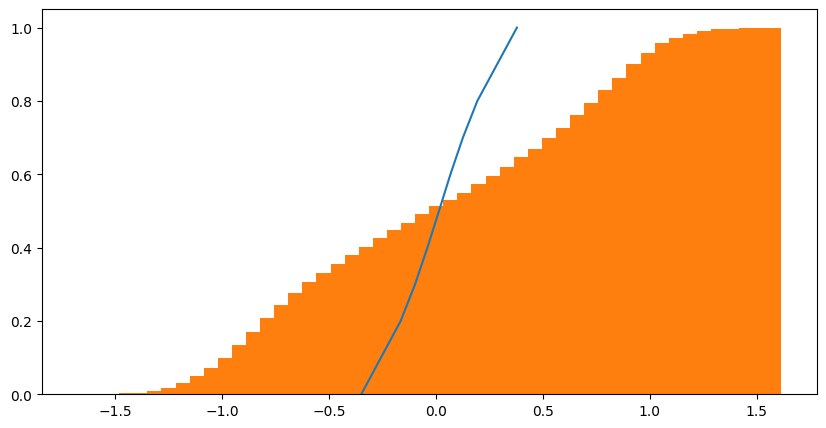

In [31]:
x_cdf, y_cdf = cdf(preds,X_test_sort,quantiles)

plt.plot(np.mean(x_cdf,axis=0),y_cdf)
plt.hist(y_test,cumulative=True, density=True,bins=50)
plt.show()